# Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/PINN

/content/drive/.shortcut-targets-by-id/1kBpsdlzoY9Dl5Og9N1a-GxSNoIkIrQV4/PINN


In [3]:
!ls -l

total 2286
drwx------ 2 root root    4096 Feb  6 06:29  ar_377_2011-02-12T00:00:00
drwx------ 2 root root    4096 Feb  6 01:28  AR_377_series
drwx------ 2 root root    4096 Feb  6 08:03  ar_7115_2017-09-06T08:36:00
drwx------ 2 root root    4096 Feb  6 07:56  AR_7115_series
drwx------ 2 root root    4096 Feb  7 10:24  ar_series_377_2011-02-12T00:00:00
drwx------ 2 root root    4096 Feb  7 23:25  ar_series_7115_2017-09-06T08:36:00
-rw------- 1 root root   94373 Feb 15 14:22  B.png
drwx------ 2 root root    4096 Feb 15 09:34  database
-rw------- 1 root root  482616 Feb 22 04:58 'extrapolation AR377.ipynb'
-rw------- 1 root root  123929 Feb  8 04:50 'extrapolation AR7115.ipynb'
-rw------- 1 root root   72789 Feb  8 11:12  hmi_cropped_binning.png
-rw------- 1 root root   75924 Feb  8 11:12  hmi_cropped.png
-rw------- 1 root root   63855 Feb  8 11:12  hmi_original.png
-rw------- 1 root root 1395900 Feb 16 02:57  Untitled0.ipynb


# Import

In [4]:
!pip install git+https://github.com/RobertJaro/NF2.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RobertJaro/NF2.git to /tmp/pip-req-build-rm5ami06
  Running command git clone --filter=blob:none --quiet https://github.com/RobertJaro/NF2.git /tmp/pip-req-build-rm5ami06
  Resolved https://github.com/RobertJaro/NF2.git to commit cbd3e684d2040d258213cdb9b0372ca177ac5f3a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.5 MB/s eta 0:00:00
  Created wheel for nf2: filename=nf2-0.2-py3-none-any.whl size=39371 sha256=ecd5b2b20439393f2ff4b88a023f5aab2d54b433f434768efc2f75c34a143d82
  Stored in directory: /tmp/pip-ephem-wheel-cache-4fou70ze/wheels/34/af/f0/ece70a6af02514037626fa92a4eadbbba8f19e7ea134186066
Successfully built nf2


In [5]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data
from nf2.train.metric import energy

# visualization
from matplotlib import pyplot as plt

In [6]:
jsoc_email = 'mgjeon@khu.ac.kr'
client = drms.Client(email=jsoc_email, verbose=True)

noaa_nums = [11158]
year = 2011
month = 2
day = 12
hour = 0
minute = 0

date = datetime(year, month, day, hour, minute)

sharp_nr = find_HARP(date, noaa_nums, client)
print(sharp_nr)
download_dir = 'AR_377'

377


In [7]:
bin = 2
spatial_norm = 160 
height = 160 
b_norm = 2500  
d_slice = [66, 658, 9, 377] # crop

dim = 256

lambda_div = 0.1 
lambda_ff = 0.1 
iterations = 10e4 
iterations = int(iterations)
decay_iterations = 5e4 
decay_iterations = int(decay_iterations)
batch_size = 1e4 
batch_size = int(batch_size)
log_interval = 1e4 
log_interval = int(log_interval)
validation_interval = 1e4 
validation_interval = int(validation_interval)
potential = True

In [8]:
base_path = './ar_%d_%s' % (sharp_nr, date.isoformat('T'))
series_base_path = './ar_series_%d_%s' % (sharp_nr, date.isoformat('T'))
series_download_dir = './AR_377_series'
bpp = os.path.join(series_base_path, 'base')

In [9]:
os.makedirs(base_path, exist_ok=True)
os.makedirs(series_base_path, exist_ok=True)
os.makedirs(bpp, exist_ok=True)
os.makedirs(series_download_dir, exist_ok=True)

In [10]:
duration = '120h'

# Download HMI FITS

In [ ]:
ds = 'hmi.sharp_cea_720s[%d][%s/%s]{Br, Bp, Bt, Br_err, Bp_err, Bt_err}' % \
     (sharp_nr, date.isoformat('_', timespec='seconds'), duration)
donwload_ds(ds, series_download_dir, client)

Streaming output truncated to the last 5000 lines.
    record: hmi.sharp_cea_720s[377][2011.02.15_06:12:00_TAI]
  filename: hmi.sharp_cea_720s.377.20110215_061200_TAI.Bt_err.fits
  -> AR_377_series/hmi.sharp_cea_720s.377.20110215_061200_TAI.Bt_err.fits
    record: hmi.sharp_cea_720s[377][2011.02.15_06:12:00_TAI]
  filename: hmi.sharp_cea_720s.377.20110215_061200_TAI.Br_err.fits
  -> AR_377_series/hmi.sharp_cea_720s.377.20110215_061200_TAI.Br_err.fits
    record: hmi.sharp_cea_720s[377][2011.02.15_06:24:00_TAI]
  filename: hmi.sharp_cea_720s.377.20110215_062400_TAI.Bp.fits
  -> AR_377_series/hmi.sharp_cea_720s.377.20110215_062400_TAI.Bp.fits
    record: hmi.sharp_cea_720s[377][2011.02.15_06:24:00_TAI]
  filename: hmi.sharp_cea_720s.377.20110215_062400_TAI.Bt.fits
  -> AR_377_series/hmi.sharp_cea_720s.377.20110215_062400_TAI.Bt.fits
    record: hmi.sharp_cea_720s[377][2011.02.15_06:24:00_TAI]
  filename: hmi.sharp_cea_720s.377.20110215_062400_TAI.Br.fits
  -> AR_377_series/hmi.sharp_cea_

,record,url,download
0,hmi.sharp_cea_720s[377][2011.02.12_00:00:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
1,hmi.sharp_cea_720s[377][2011.02.12_00:00:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
2,hmi.sharp_cea_720s[377][2011.02.12_00:00:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
3,hmi.sharp_cea_720s[377][2011.02.12_00:00:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
4,hmi.sharp_cea_720s[377][2011.02.12_00:00:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
...,...,...,...
3595,hmi.sharp_cea_720s[377][2011.02.16_23:48:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
3596,hmi.sharp_cea_720s[377][2011.02.16_23:48:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
3597,hmi.sharp_cea_720s[377][2011.02.16_23:48:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....
3598,hmi.sharp_cea_720s[377][2011.02.16_23:48:00_TAI],http://jsoc.stanford.edu/SUM66/D1606751764/S00...,/content/drive/MyDrive/PINN/AR_377_series/hmi....


# Initial Training

In [ ]:
# scan all data files
hmi_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br.fits')))  # z
err_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp_err.fits')))  # x
err_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt_err.fits')))  # y
err_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br_err.fits')))  # z

hmi_p = hmi_p_files[0]
hmi_t = hmi_t_files[0]
hmi_r = hmi_r_files[0]
err_p = err_p_files[0]
err_t = err_t_files[0]
err_r = err_r_files[0]

filename = os.path.basename(hmi_p)

hmi_cube, error_cube, meta_info = load_hmi_data([hmi_p, err_p, hmi_r, err_r, hmi_t, err_t])

fig, ax = plt.subplots()
ax.imshow(hmi_cube[..., 0].transpose(), origin='lower', cmap='gray')
ax.set_title(f'{hmi_cube[..., 0].transpose().shape} {filename}')
fig.savefig('./hmi_original.png')

if d_slice is not None:
  hmi_cube = hmi_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
  error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]

fig, ax = plt.subplots()
ax.imshow(hmi_cube[..., 0].transpose(), origin='lower', cmap='gray')
ax.set_title(f'{hmi_cube[..., 0].transpose().shape} {filename}')
fig.savefig('./hmi_cropped.png')

if bin > 1:
  hmi_cube = block_reduce(hmi_cube, (bin, bin, 1), np.mean)
  error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)

fig, ax = plt.subplots()
ax.imshow(hmi_cube[..., 0].transpose(), origin='lower', cmap='gray')
ax.set_title(f'{hmi_cube[..., 0].transpose().shape} {filename}')
fig.savefig('./hmi_cropped_binning.png')


In [ ]:
trainer = NF2Trainer(base_path, hmi_cube, error_cube, height, spatial_norm, b_norm,
                     meta_info=meta_info, dim=dim,
                     use_potential_boundary=potential, lambda_div=lambda_div, lambda_ff=lambda_ff,
                     decay_iterations=decay_iterations, meta_path=None)

In [ ]:
trainer.train(iterations, batch_size, log_interval, validation_interval, num_workers=os.cpu_count())

# Series Training

In [ ]:
new_meta_path = './ar_377_2011-02-12T00:00:00/extrapolation_result.nf2'

In [ ]:
series_iterations = 2000
series_batch_size = int(1e4)
series_log_interval = 2000
series_validation_interval = -1

In [ ]:
# scan all data files
hmi_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br.fits')))  # z
err_p_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bp_err.fits')))  # x
err_t_files = sorted(glob.glob(os.path.join(series_download_dir, '*Bt_err.fits')))  # y
err_r_files = sorted(glob.glob(os.path.join(series_download_dir, '*Br_err.fits')))  # z

for hmi_p, hmi_t, hmi_r, err_p, err_t, err_r in zip(hmi_p_files, hmi_t_files, hmi_r_files,
                                                    err_p_files, err_t_files, err_r_files):
    file_id = os.path.basename(hmi_p).split('.')[3]
    bp = os.path.join(bpp, file_id)

    # check if finished
    final_model_path = os.path.join(bp, 'final.pt')
    print(final_model_path)
    #print(os.path.exists(final_model_path))
    if os.path.exists(final_model_path):
        new_meta_path = final_model_path
        continue
    
    # data pre-processing; same as for the single extrapolation
    hmi_cube, error_cube, meta_info = load_hmi_data([hmi_p, err_p, hmi_r, err_r, hmi_t, err_t])
    
    if d_slice is not None:
      hmi_cube = hmi_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
      error_cube = error_cube[d_slice[0]:d_slice[1], d_slice[2]:d_slice[3]]
    if bin > 1:
      hmi_cube = block_reduce(hmi_cube, (bin, bin, 1), np.mean)
      error_cube = block_reduce(error_cube, (bin, bin, 1), np.mean)
    print(hmi_cube.shape)
    trainer = NF2Trainer(bp, hmi_cube, error_cube, height, spatial_norm, b_norm, 
                         meta_info=meta_info, dim=dim, 
                         lambda_div=lambda_div, lambda_ff=lambda_ff,
                         meta_path=new_meta_path, use_potential_boundary=potential)
    trainer.train(series_iterations, series_batch_size, 
                  series_log_interval, series_validation_interval)
    new_meta_path = final_model_path

./ar_series_377_2011-02-12T00:00:00/base/20110212_000000_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_001200_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_002400_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_003600_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_004800_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_010000_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_011200_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_012400_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_013600_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_014800_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_020000_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_021200_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_022400_TAI/final.pt
./ar_series_377_2011-02-12T00:00:00/base/20110212_023600_TAI/final.pt
./ar_series_377_2011

# Evaluation

In [ ]:
nf2_paths = sorted(glob.glob(os.path.join(bpp, '**', 'extrapolation_result.nf2')))

# save results as npy files
eval_magnetic_field_path = os.path.join(series_base_path, 'eval_magnetic_field')
os.makedirs(eval_magnetic_field_path, exist_ok=True)
magnetic_field_files = []
for path in nf2_paths:
  print(path)
  f = os.path.join(eval_magnetic_field_path, '%s.npy' % path.split('/')[-2])
  if os.path.exists(f): 
    magnetic_field_files += [f]
    continue
  b = load_cube(path, progress=True)
  np.save(f, b)
  magnetic_field_files += [f]

series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in magnetic_field_files]

./ar_series_377_2011-02-12T00:00:00/base/20110212_000000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_001200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_002400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_003600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_004800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_010000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_011200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_012400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_013600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_014800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_020000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/base/20110212_0212

100%|██████████| 8715/8715 [00:11<00:00, 732.09it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_224800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.24it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110212_230000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.19it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_231200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 772.00it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_232400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1011.50it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_233600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 816.65it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_234800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 870.41it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_000000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 840.69it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_001200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.21it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_002400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 913.25it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_003600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1019.07it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_004800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 853.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_010000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 846.69it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_011200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 771.57it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_012400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 910.56it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_013600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1033.50it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_014800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 853.74it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_020000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 861.04it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_021200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 857.97it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_022400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1003.97it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_023600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 912.58it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_024800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 843.18it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_030000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 845.16it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_031200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 852.61it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_032400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 994.04it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_033600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 905.81it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_034800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 861.65it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_040000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 857.00it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_041200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 879.37it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_042400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1010.10it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_043600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 871.73it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_044800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.17it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_050000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 837.40it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_051200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 792.03it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_052400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1004.06it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_053600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 875.69it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_054800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 843.27it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_060000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 861.90it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_061200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 867.23it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_062400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1015.36it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_063600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 906.82it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_064800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.13it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_070000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 865.63it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_071200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 917.74it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_072400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1025.99it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_073600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 900.27it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_074800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.20it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_080000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 861.88it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_081200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 899.95it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_082400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 964.95it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_083600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 869.61it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_084800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 873.16it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_090000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 820.73it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_091200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 843.98it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_092400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1003.87it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_093600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 893.49it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_094800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.21it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_100000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 849.05it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_101200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 906.92it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_102400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1013.43it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_103600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 907.65it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_104800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 840.02it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_110000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 838.28it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_111200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 884.87it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_112400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1037.69it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_113600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 902.01it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_114800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 867.09it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_120000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 852.81it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_121200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 961.06it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_122400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1022.95it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_123600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 867.50it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_124800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 861.80it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_130000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 844.71it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_131200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 800.92it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_132400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1023.77it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_133600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 890.86it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_134800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.64it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_140000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 846.11it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_141200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 880.43it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_142400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1014.18it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_143600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 903.95it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_144800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.24it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_150000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 849.84it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_151200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 933.50it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_152400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1040.87it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_153600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 883.52it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_154800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.97it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_160000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 858.32it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_161200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 938.96it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_162400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 957.27it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_163600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 866.35it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_164800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 869.10it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_170000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 856.08it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_171200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 778.53it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_172400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1021.79it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_173600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 891.60it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_174800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 854.60it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_180000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 865.60it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_181200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 985.16it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_182400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 992.74it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_183600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 857.44it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_184800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 848.04it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_190000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 862.62it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_191200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1007.45it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_192400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 934.39it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_193600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 845.66it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_194800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 857.33it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_200000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 860.90it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_201200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 992.97it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_202400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 977.07it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_203600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 848.27it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_204800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 864.37it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_210000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 844.61it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_211200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 790.09it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_212400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1029.01it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_213600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 876.00it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_214800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 851.07it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_220000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 842.82it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_221200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 892.39it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_222400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1021.08it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_223600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 910.95it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_224800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 839.78it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110213_230000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 853.28it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_231200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 853.39it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_232400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1009.59it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_233600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 913.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110213_234800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 841.73it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_000000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 866.83it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_001200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 917.94it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_002400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 978.50it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_003600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 911.55it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_004800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 847.85it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_010000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 852.26it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_011200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:11<00:00, 766.54it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_012400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1002.84it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_013600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 935.60it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_014800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 833.54it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_020000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 865.32it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_021200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 858.06it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_022400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1016.21it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_023600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 956.18it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_024800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 850.05it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_030000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:10<00:00, 843.78it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_031200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 878.07it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_032400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1061.09it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_033600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 928.04it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_034800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 900.06it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_040000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 886.01it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_041200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 910.61it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_042400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:08<00:00, 1017.80it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_043600_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 920.27it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_044800_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 892.90it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_050000_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 881.44it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_051200_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 931.89it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110214_052400_TAI/extrapolation_result.nf2


100%|██████████| 8715/8715 [00:09<00:00, 884.51it/s] 


./ar_series_377_2011-02-12T00:00:00/base/20110214_053600_TAI/extrapolation_result.nf2


 56%|█████▌    | 4863/8715 [00:05<00:04, 841.32it/s]


KeyboardInterrupt: ignored

In [ ]:
#state = torch.load('./ar_series_377_2011-02-12T00:00:00/base/20110212_080000_TAI/final.pt')
#state

In [ ]:
eval_energy_path = os.path.join(series_base_path, 'eval_energy')
os.makedirs(eval_energy_path, exist_ok=True)
energy_files = []

for path in magnetic_field_files:
  f = os.path.join(eval_energy_path, os.path.basename(path))
  if os.path.exists(f): 
    energy_files += [f]
    continue
  b = np.load(path)
  me = energy(b)
  np.save(f, me)
  energy_files += [f]

energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in energy_files]

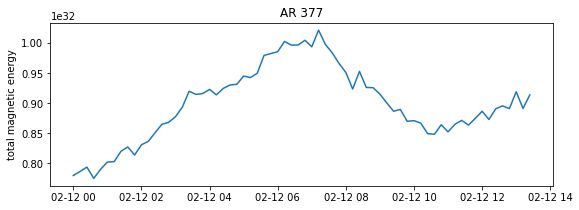

In [ ]:
cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3

plt.figure(figsize=(9, 3))
plt.plot(energy_series_dates, [np.load(f).sum()*dV for f in energy_files])
plt.title('AR 377')
plt.ylabel('total magnetic energy')
figure_energy_path = os.path.join(series_base_path, './energy.png')
plt.savefig(figure_energy_path, dpi=300)
plt.show()

In [ ]:
eval_free_energy_path = os.path.join(series_base_path, 'eval_free_energy')
os.makedirs(eval_free_energy_path, exist_ok=True)
free_energy_files = []

for path in magnetic_field_files:
  f = os.path.join(eval_free_energy_path, os.path.basename(path))
  if os.path.exists(f): 
    free_energy_files += [f]
    continue
  b = np.load(path)
  free_me = get_free_mag_energy(b)
  np.save(f, free_me)
  free_energy_files += [f]

free_energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in free_energy_files]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Potential Field:  85%|████████▌ | 7421/8715 [03:08<00:32, 39.36it/s]


KeyboardInterrupt: ignored

In [ ]:
cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3

plt.figure(figsize=(9, 3))
plt.plot(free_energy_series_dates, [np.load(f).sum()*dV for f in free_energy_files])
plt.title('AR 377')
plt.ylabel('total free magnetic energy')
figure_free_energy_path = os.path.join(series_base_path, './free_energy.png')
plt.savefig(figure_free_energy_path, dpi=300)
plt.show()

# A

In [ ]:
nf2_paths = sorted(glob.glob(os.path.join(bpp, '**', 'extrapolation_result.nf2')))

eval_free_energy_path = os.path.join(series_base_path, 'eval_free_energy')
os.makedirs(eval_free_energy_path, exist_ok=True)
free_energy_files = []

for path in nf2_paths:
  print(path)
  f = os.path.join(eval_free_energy_path, os.path.basename(os.path.dirname(path))) + '.npy'
  print(f)
  if os.path.exists(f): 
    free_energy_files += [f]
    continue
  b = load_cube(path, progress=True)
  free_me = get_free_mag_energy(b)
  np.save(f, free_me)
  free_energy_files += [f]

free_energy_series_dates = [datetime.strptime(os.path.basename(f), '%Y%m%d_%H%M%S_TAI.npy') for f in free_energy_files]

cm_per_pixel = 360e5 * bin
dV = cm_per_pixel**3

plt.figure(figsize=(9, 3))
plt.plot(free_energy_series_dates, [np.load(f).sum()*dV for f in free_energy_files])
plt.title('AR 377')
plt.ylabel('total free magnetic energy')
figure_free_energy_path = os.path.join(series_base_path, './free_energy.png')
plt.savefig(figure_free_energy_path, dpi=300)
plt.show()

./ar_series_377_2011-02-12T00:00:00/base/20110212_000000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_000000_TAI.npy


100%|██████████| 8715/8715 [00:11<00:00, 765.19it/s]
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_001200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_001200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.58it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_002400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_002400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.28it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_003600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_003600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.40it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_004800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_004800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.46it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_010000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_010000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:42<00:00, 39.24it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_011200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_011200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.28it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_012400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_012400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.27it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_013600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_013600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.58it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_014800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_014800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.58it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_020000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_020000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.48it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_021200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_021200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.33it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_022400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_022400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:42<00:00, 39.19it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_023600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_023600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.32it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_024800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_024800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:39<00:00, 39.67it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_030000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_030000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.53it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_031200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_031200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:39<00:00, 39.62it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_032400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_032400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.47it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_033600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_033600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.56it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_034800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_034800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.47it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_040000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_040000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.54it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_041200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_041200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:39<00:00, 39.62it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_042400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_042400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.46it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_043600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_043600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_044800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_044800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.54it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_050000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_050000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.53it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_051200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_051200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.41it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_052400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_052400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.56it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_053600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_053600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_054800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_054800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:39<00:00, 39.69it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_060000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_060000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.60it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_061200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_061200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.57it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_062400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_062400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.43it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_063600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_063600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.49it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_064800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_064800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.52it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_070000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_070000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.41it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_071200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_071200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.54it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_072400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_072400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.40it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_073600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_073600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.46it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_074800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_074800_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.43it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_080000_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_080000_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:41<00:00, 39.42it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_081200_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_081200_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.46it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_082400_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_082400_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:39<00:00, 39.65it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_083600_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_083600_TAI.npy


Potential Field: 100%|██████████| 8715/8715 [03:40<00:00, 39.61it/s]


./ar_series_377_2011-02-12T00:00:00/base/20110212_084800_TAI/extrapolation_result.nf2
./ar_series_377_2011-02-12T00:00:00/eval_free_energy/20110212_084800_TAI.npy


Potential Field:  97%|█████████▋| 8474/8715 [03:35<00:05, 40.22it/s]